instructions: Run the program in the order of the cells :)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
import itertools
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from scipy.sparse import csc_matrix
from sklearn.preprocessing import StandardScaler



In [9]:
df = pd.read_csv('simple_classification.csv')

X = df[['x1', 'x2']].values
y = df['y'].values


# data preprocessing: {0,1} to {-1,1}
y = 2 * y - 1

# Add a bias term to the features
X = np.c_[X, np.ones(X.shape[0])]


## question 1.a.

In [10]:
def svm_primal(X, y, max_iter = 4000, verbose = False):
    N = X.shape[0]
    n = X.shape[1]
    P = np.eye(n)
    q = np.zeros(n)
    G = -np.diag(y) @ X
    h = -np.ones(N)
    
    w = solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp', max_iter = max_iter, verbose=verbose)
    
    return w

In [11]:
w = svm_primal(X, y, max_iter=4000, verbose= False)
print("Resulting vector of weights (w):", w)

Resulting vector of weights (w): [ 1.19553571  0.34700045 -6.52243901]


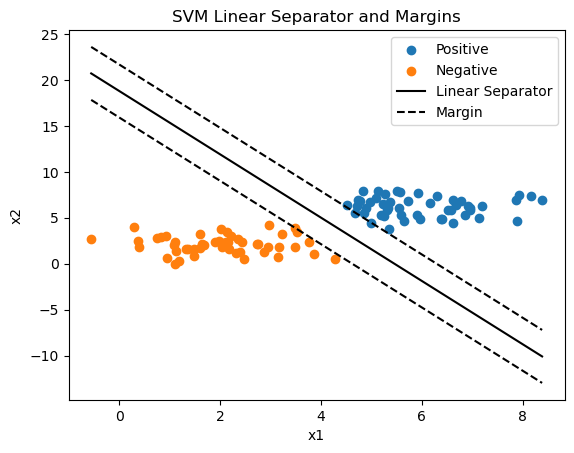

In [12]:
# Plot the data with the linear separator
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Positive')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Negative')

# Linear separator: w[0] * x1 + w[1] * x2 + w[2] = 0
# => x2 = -(w[0] / w[1]) * x1 - w[2] / w[1]
x1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2 = -(w[0] / w[1]) * x1 - w[2] / w[1]
plt.plot(x1, x2, color='k', label='Linear Separator')

# Margin lines: x2 = -(w[0] / w[1]) * x1 - (w[2] ± 1) / w[1]

x2_margin_positive = -(w[0] / w[1]) * x1 - (w[2] + 1) / w[1]
x2_margin_negative = -(w[0] / w[1]) * x1 - (w[2] - 1) / w[1]
plt.plot(x1, x2_margin_positive, color='black', linestyle='--', label='Margin')
plt.plot(x1, x2_margin_negative, color='black', linestyle='--')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('SVM Linear Separator and Margins')
plt.show()


## question 1.b.

In [13]:
def svm_dual(X, y, max_iter = 4000, verbose = False):
    
    N = X.shape[0]
    G = np.diag(y) @ X
    P = 0.5 * G @ G.T
    q = -np.ones(N)
    GG = -np.eye(N)
    h = np.zeros(N)
    
    alpha = solve_qp(csc_matrix(P), q, csc_matrix(GG), h, solver='osqp', max_iter=max_iter, verbose=verbose)
    
    w= G.T @ alpha
    return alpha, w

In [14]:
alpha, w = svm_dual(X, y)


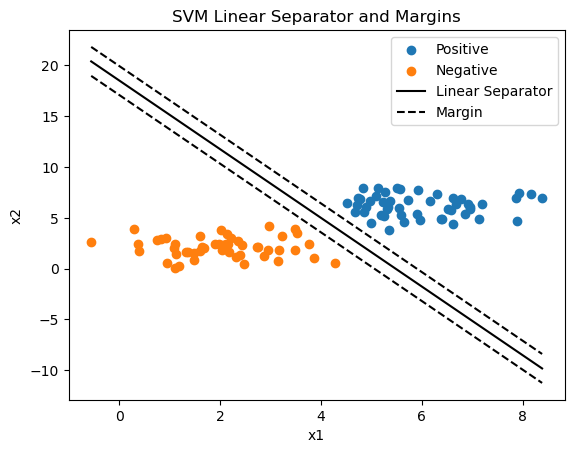

In [15]:
# Identify support vectors (non-zero alpha values)
support_vectors = np.where(alpha > 1e-6)[0]

# Plot the data with the linear separator
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Positive')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Negative')

# Linear separator: w[0] * x1 + w[1] * x2 + w[2] = 0
# => x2 = -(w[0] / w[1]) * x1 - w[2] / w[1]
x1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2 = -(w[0] / w[1]) * x1 - w[2] / w[1]
plt.plot(x1, x2, color='k', label='Linear Separator')

# Margin lines: x2 = -(w[0] / w[1]) * x1 - (w[2] ± 1) / w[1]

x2_margin_positive = -(w[0] / w[1]) * x1 - (w[2] + 1) / w[1]
x2_margin_negative = -(w[0] / w[1]) * x1 - (w[2] - 1) / w[1]
plt.plot(x1, x2_margin_positive, color='black', linestyle='--', label='Margin')
plt.plot(x1, x2_margin_negative, color='black', linestyle='--')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('SVM Linear Separator and Margins')
plt.show()


## question 2

In [16]:
# Load the dataset
data = pd.read_csv('simple_nonlin_classification.csv')

# Split the data into training and testing sets
X = data[['x1', 'x2']].values
y = data['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [17]:
def plot_data(X, y, zoom_out=False, s=None):
    if zoom_out:
        x_min = np.amin(X[:, 0])
        x_max = np.amax(X[:, 0])
        y_min = np.amin(X[:, 1])
        y_max = np.amax(X[:, 1])
        plt.axis([x_min-1, x_max+1, y_min-1, y_max+1])
    plt.scatter(X[:,0], X[:,1], c=y, s=s, cmap=matplotlib.colors.ListedColormap(['blue','red']))

def plot_classifier_z_kernel(alpha, X, y, ker, s=None, kernel_param=None):
        
    x_min = np.amin(X[:, 0])
    x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1])
    y_max = np.amax(X[:, 1])
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    xx, yy = np.meshgrid(xx, yy)
    N = X.shape[0]
    z = np.zeros(xx.shape)
    for i, j in itertools.product(range(xx.shape[0]), range(xx.shape[1])):
        z[i, j] = sum([y[k]*alpha[k]*ker(X[k,:], np.array([xx[i,j],yy[i,j]]),kernel_param) for k in range(N)])
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=['red', 'black', 'blue'], linestyles=['--','-', '--'])
    plot_data(X, y, s=s)

In [18]:
def support_vectors(alpha, thresh=0.0001):
    return np.argwhere(np.abs(alpha) > thresh).reshape(-1)


def highlight_support_vectors(X, alpha):
    sv = support_vectors(alpha)
    plt.scatter(X[sv,0], X[sv,1], s=300, linewidth=3, facecolors='none', edgecolors='k')

In [19]:
def kernel(x, y):
    return (1+x.T @ y)**2 

# Define kernel functions
def polynomial_kernel(x, y, degree = 3):
    return (1+x.T @ y)**degree

def RBF_kernel(x, y, gamma=1.0):
    return np.exp(-gamma * np.dot((x - y).T, (x - y)))


# SVM dual program with kernel
def svm_dual_kernel(X, y, ker, max_iter=20000, verbose=False, kernel_param=None):
    N = X.shape[0]
    P = np.empty((N, N))
    for i, j in itertools.product(range(N), range(N)):
        P[i, j] = y[i] * y[j] * ker(X[i,:], X[j,:], kernel_param)
    P = 0.5*(P+P.T)
    P = 0.5*P
    q = -np.ones(N)
    GG = -np.eye(N)
    h = np.zeros(N)
    alpha = solve_qp(csc_matrix(P), q, csc_matrix(GG), h, solver='osqp', max_iter=max_iter, verbose=verbose)
    return alpha

In [20]:
def evaluate_model(X_train, y_train, X_test, y_test, kernel_func, kernel_param):
    alpha = svm_dual_kernel(X_train, y_train, kernel_func, kernel_param = kernel_param)
    support_vector_indices = support_vectors(alpha)
    support_vectors_ = X_train[support_vector_indices]
    support_vector_labels = y_train[support_vector_indices]
    alpha_sv = alpha[support_vector_indices]
    
    def decision_function(X):
        z = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            z[i] = np.sum(alpha_sv * support_vector_labels * np.array([kernel_func(X[i], sv) for sv in support_vectors_]))

        return z
    
    y_pred_train = np.sign(decision_function(X_train))
    y_pred_test = np.sign(decision_function(X_test))
    
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    
    return train_error, test_error, alpha

kernels = [(polynomial_kernel,2), (polynomial_kernel,3) ,(polynomial_kernel,4),
           (RBF_kernel, 0.1), (RBF_kernel, 1), (RBF_kernel, 10)]

results = []
for kernel_func in kernels:
    train_error, test_error, alpha = evaluate_model(X_train, y_train, X_test, y_test, kernel_func[0], kernel_func[1])
    results.append((kernel_func[0].__name__,kernel_func[1] , train_error, test_error, alpha))


In [21]:
def error_plot(labels, train_errors, test_errors):
    # Plot the errors
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_errors, width, label='Train Error')
    rects2 = ax.bar(x + width/2, test_errors, width, label='Test Error')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Kernel and Parameter')
    ax.set_ylabel('Error Rate')
    ax.set_title('Error Rate by Kernel and Parameter')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    # Function to add labels above the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


In [22]:
# Organize the results for plotting
labels = [f"{name}\nparam={param}" for name, param, _, _, _ in results]
train_errors = [train_error for _, _, train_error, _, _ in results]
test_errors = [test_error for _, _, _, test_error, _ in results]


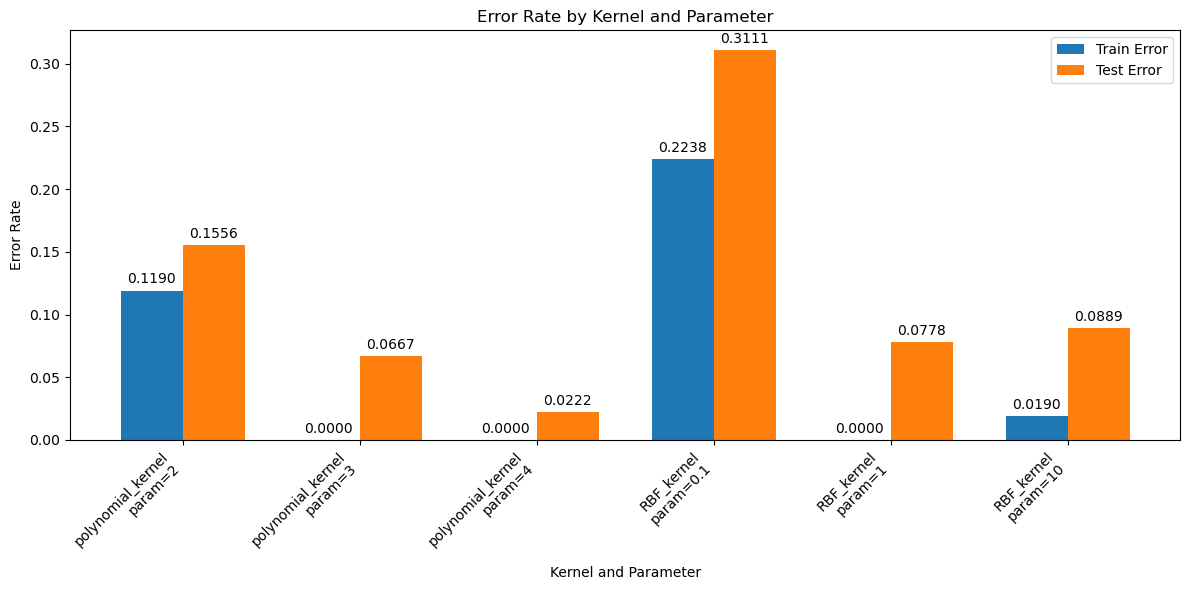

In [23]:
error_plot(labels, train_errors, test_errors)

In [24]:
unique_kernels = set(kernel_func for kernel_func, _ in kernels)
# Find the best model for each kernel function
best_models = {}
for kernel in unique_kernels:
    best_model = min(
        (result for result in results if result[0] == kernel.__name__),
        key=lambda x: x[3]  # x[3] is the test error
    )
    best_models[kernel] = best_model

# Print the best model for each kernel function
for kernel, model in best_models.items():
    print(f"Best model for {kernel.__name__}:\n  Parameter: {model[1]}\n  Train Error: {model[2]:.3f}\n  Test Error: {model[3]:.3f}\n")


Best model for RBF_kernel:
  Parameter: 1
  Train Error: 0.000
  Test Error: 0.078

Best model for polynomial_kernel:
  Parameter: 4
  Train Error: 0.000
  Test Error: 0.022



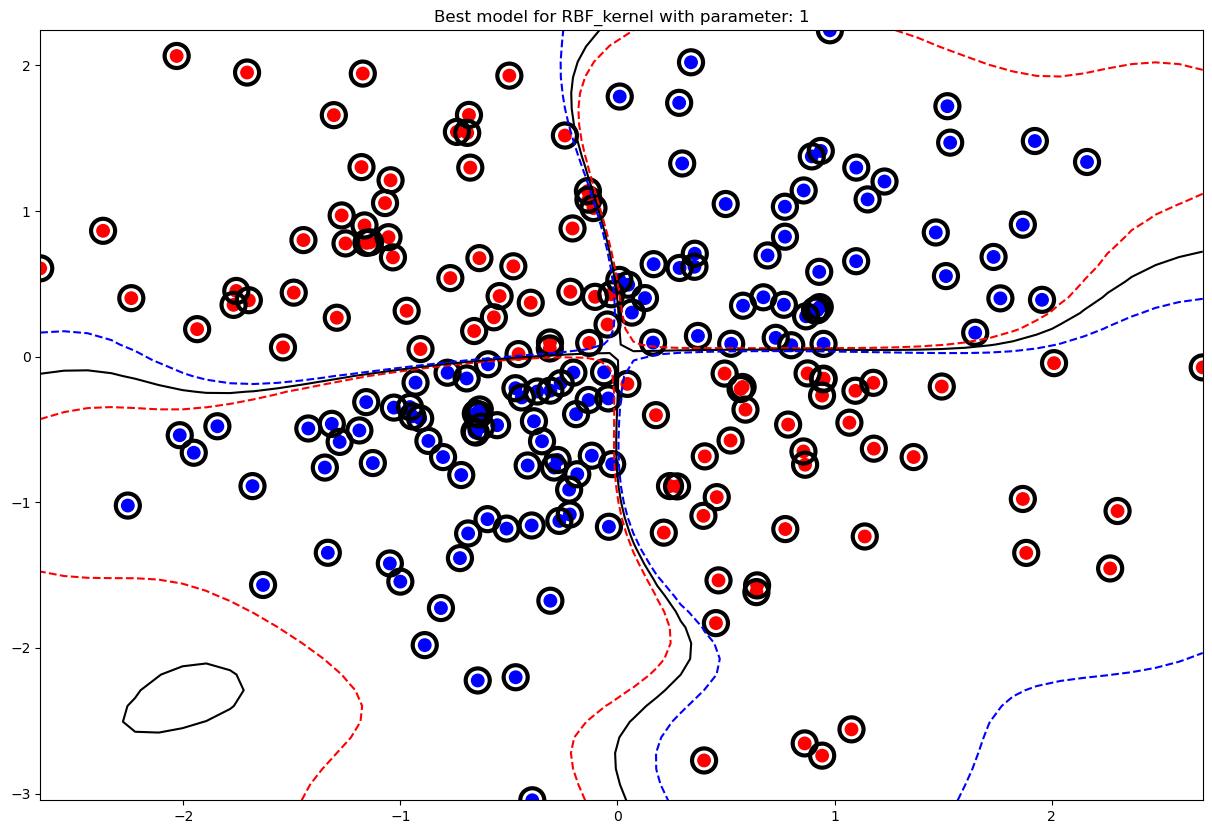

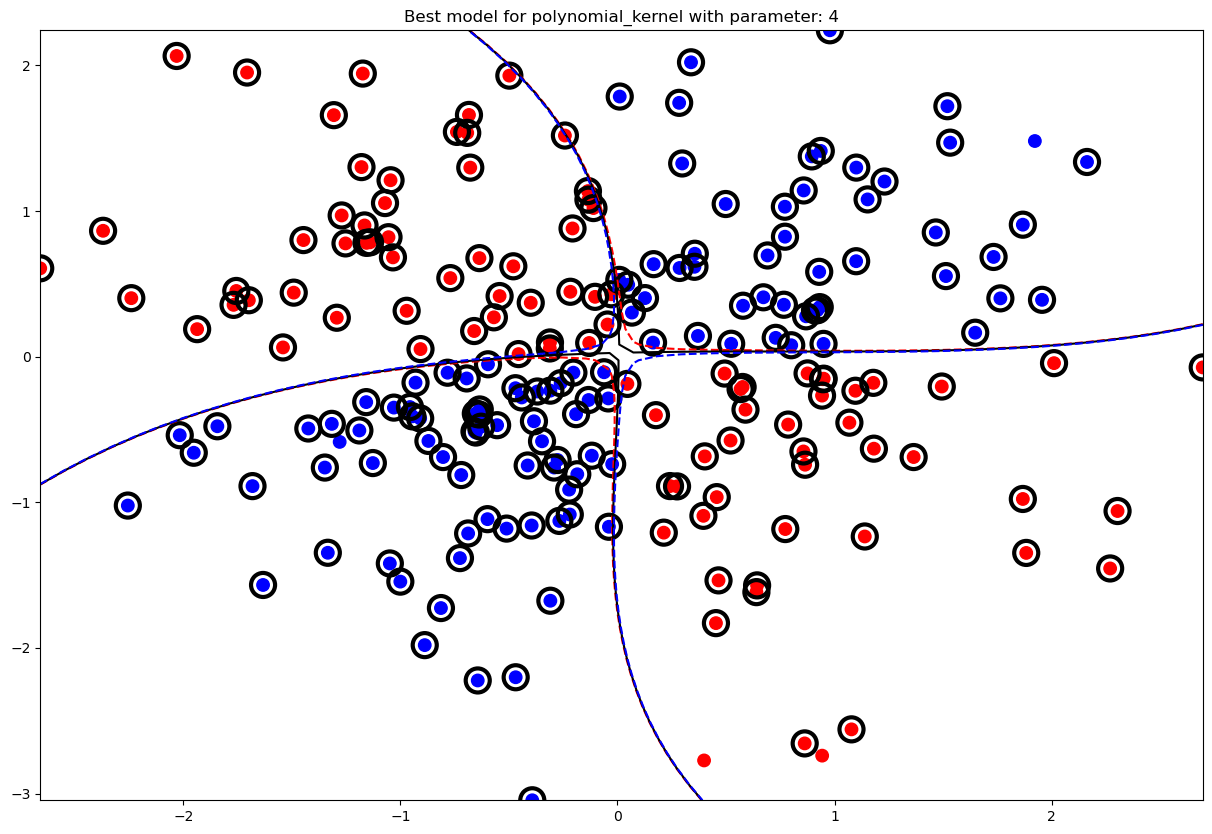

In [25]:
for kernel, model in best_models.items():
    kernel_func = model[0]
    params = model[1]
    alpha = model[4]
    plot_classifier_z_kernel(alpha, X_train, y_train, eval(kernel_func), s=80, kernel_param=params)
    highlight_support_vectors(X_train, alpha)
    plt.title(f"Best model for {kernel_func} with parameter: {params}")
    plt.show()


## question 3:

In [26]:
class SVM:
    def __init__(self, kernel='rbf', C=1.0, gamma=1, degree=3):
        self.kernel = kernel
        self.degree = degree
        self.C = C
        self.gamma = gamma
        self.alpha = None
        self.support_vectors_ = None
        self.support_vector_labels_ = None
        self.alpha_sv = None

    def _kernel_function(self, x, y):
        if self.kernel == 'polynomial':
            return polynomial_kernel(x, y, self.degree)
        elif self.kernel in ['rbf', 'RBF']:
            return RBF_kernel(x, y, self.gamma)
        else:
            raise ValueError("Unsupported kernel. Use 'polynomial' or 'rbf'")
    
    def fit(self, X, y):
        N = X.shape[0]
        P = np.empty((N, N))
        for i, j in itertools.product(range(N), range(N)):
            P[i, j] = y[i] * y[j] * self._kernel_function(X[i, :], X[j, :])
        P = 0.5 * (P + P.T)
        q = -np.ones(N)
        GG = np.vstack([-np.eye(N), np.eye(N)])
        h = np.hstack([np.zeros(N), np.ones(N) * self.C])
        self.alpha = solve_qp(csc_matrix(P), q, csc_matrix(GG), h, solver='osqp')
        self.support_vector_indices_ = support_vectors(self.alpha)
        self.support_vectors_ = X[self.support_vector_indices_]
        self.support_vector_labels_ = y[self.support_vector_indices_]
        self.alpha_sv = self.alpha[self.support_vector_indices_]

    def decision_function(self, X):
        z = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            z[i] = np.sum(self.alpha_sv * self.support_vector_labels_ * np.array([self._kernel_function(X[i], sv) for sv in self.support_vectors_]))
        return z

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


## question 4:

In [34]:
data = pd.read_csv('Processed Wisconsin Diagnostic Breast Cancer.csv')

X = data.drop(columns=['diagnosis']).values
y = data['diagnosis'].values

# Normalize the features
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# those functions are now modified for the the new dataset

def plot_data(X, y, zoom_out=False, s=None):
    if zoom_out:
        x_min = np.amin(X[:, 0])
        x_max = np.amax(X[:, 0])
        y_min = np.amin(X[:, 1])
        y_max = np.amax(X[:, 1])
        plt.axis([x_min-1, x_max+1, y_min-1, y_max+1])
    plt.scatter(X[:,0], X[:,1], c=y, s=s, cmap=matplotlib.colors.ListedColormap(['blue','red']))

def plot_classifier_z_kernel(alpha, X, y, ker, s=None, **kernel_param):
    # Select two features to visualize
    X_vis = X[:, :2]
    x_min = np.amin(X_vis[:, 0])
    x_max = np.amax(X_vis[:, 0])
    y_min = np.amin(X_vis[:, 1])
    y_max = np.amax(X_vis[:, 1])
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    xx, yy = np.meshgrid(xx, yy)
    N = X_vis.shape[0]
    z = np.zeros(xx.shape)
    for i, j in itertools.product(range(xx.shape[0]), range(xx.shape[1])):
        z[i, j] = sum([y[k]*alpha[k]*ker(X_vis[k,:], np.array([xx[i,j],yy[i,j]]), **kernel_param) for k in range(N)])
    plt.rcParams["figure.figsize"] = [15, 10]
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=['red', 'black', 'blue'], linestyles=['--','-', '--'])
    plt.contourf(xx, yy, z, levels=20, cmap='RdBu', alpha=0.5)  # Adding filled contour for better visualization
    plot_data(X_vis, y, s=s)


In [36]:
def evaluate_model_svm(X_train, y_train, X_test, y_test, kernel, kernel_param):
    svm_model = SVM(kernel=kernel, C=1.0, **kernel_param)
    svm_model.fit(X_train, y_train)
    train_error = 1 - svm_model.score(X_train, y_train)
    test_error = 1 - svm_model.score(X_test, y_test)
    return train_error, test_error, svm_model.alpha


In [38]:
kernels = [
    ('polynomial', {'degree': 2}),
    ('polynomial', {'degree': 3}),
    ('rbf', {'gamma': 0.1}),
    ('rbf', {'gamma': 1}),
    ('rbf', {'gamma': 10})
]

results = []
for kernel, params in kernels:
    train_error, test_error, alpha = evaluate_model_svm(X_train, y_train, X_test, y_test, kernel, params)
    results.append((kernel, params, train_error, test_error, alpha))


In [39]:
labels = [f"{name}\nparam={param}" for name, param, _, _, _ in results]
train_errors = [train_error for _, _, train_error, _, _ in results]
test_errors = [test_error for _, _, _, test_error, _ in results]


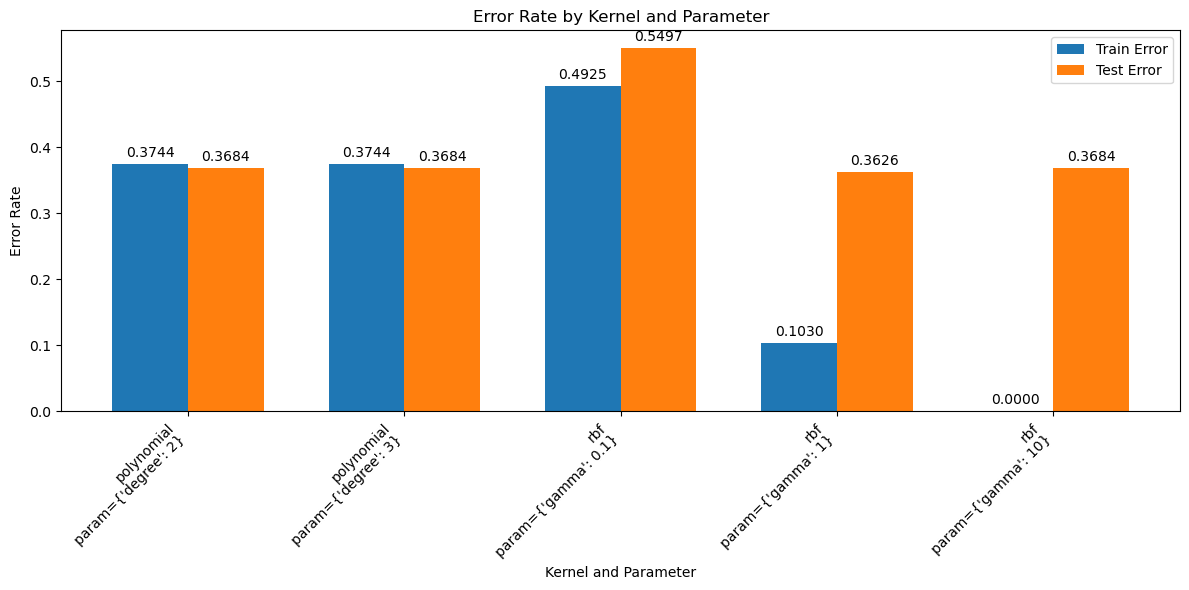

In [40]:
error_plot(labels, train_errors, test_errors)

In [41]:
# Find the best model for each kernel function
unique_kernels = set(kernel for kernel, _ in kernels)
best_models = {}
for kernel in unique_kernels:
    best_model = min(
        (result for result in results if result[0] == kernel),
        key=lambda x: x[3]
    )
    best_models[kernel] = best_model

# Print the best model for each kernel function
for kernel, model in best_models.items():
    print(f"Best model for {kernel}:\n  Parameter: {model[1]}\n  Train Error: {model[2]:.3f}\n  Test Error: {model[3]:.3f}\n")


Best model for rbf:
  Parameter: {'gamma': 1}
  Train Error: 0.103
  Test Error: 0.363

Best model for polynomial:
  Parameter: {'degree': 2}
  Train Error: 0.374
  Test Error: 0.368



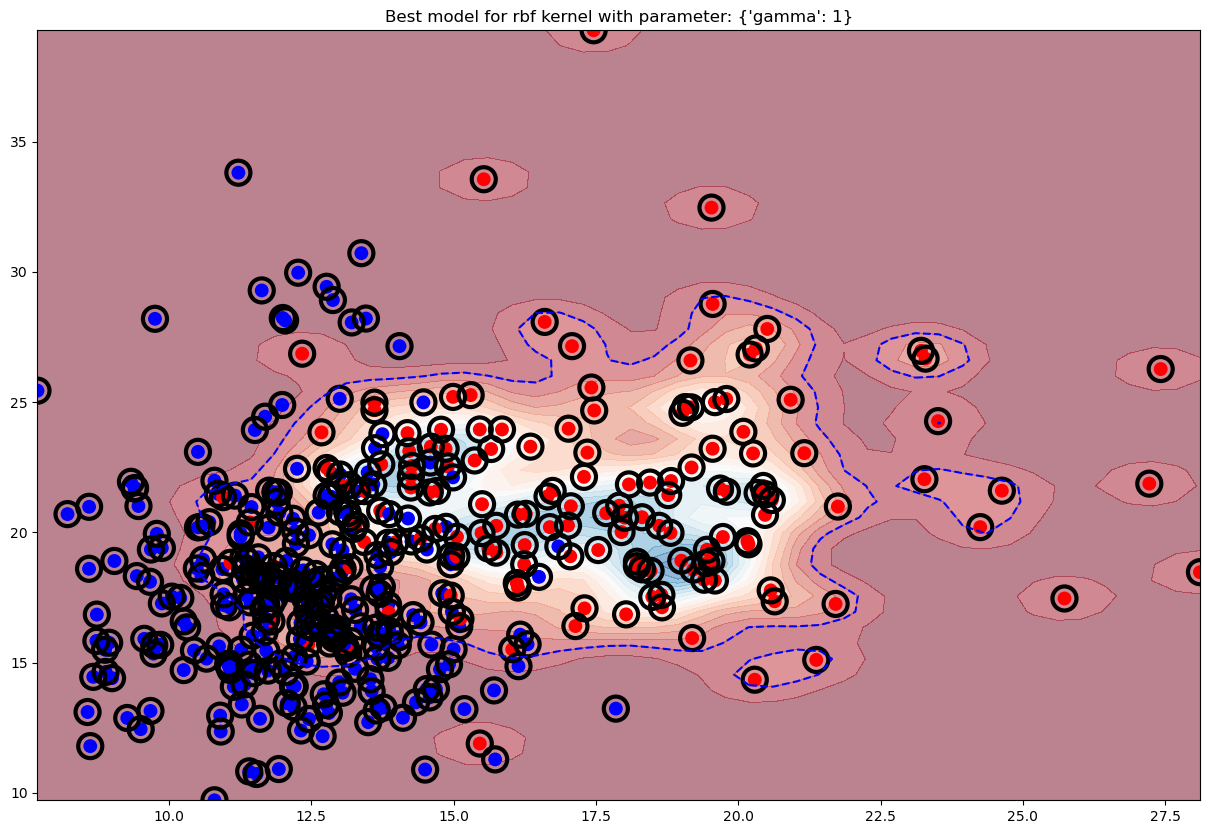

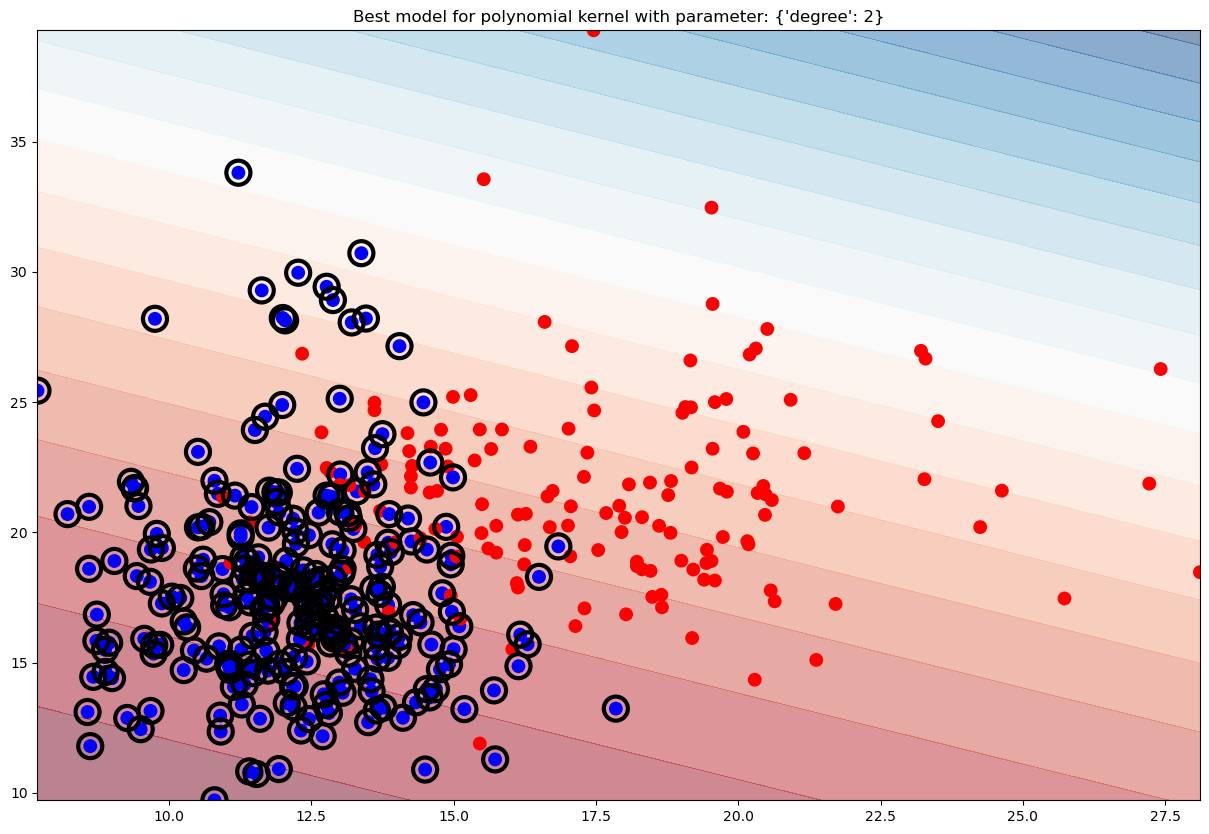

In [42]:
for kernel, model in best_models.items():
    kernel_func = model[0]
    params = model[1]
    alpha = model[4]
    if kernel_func == 'polynomial':
        plot_classifier_z_kernel(alpha, X_train, y_train, polynomial_kernel, s=80, **params)
    elif kernel_func == 'rbf':
        plot_classifier_z_kernel(alpha, X_train, y_train, RBF_kernel, s=80, **params)
    highlight_support_vectors(X_train, alpha)
    plt.title(f"Best model for {kernel_func} kernel with parameter: {params}")
    plt.show()
